In [1]:
# import required packages
# source: https://www.kaggle.com/allunia/patterns-of-colorectal-cancer-wally

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set(style='darkgrid')

# Import classifiers used:
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

# Data Transformation
from sklearn.kernel_approximation import Nystroem
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer


# Import ovo and ovr related stuff
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import VotingClassifier

# Pre-processing Data:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, cross_val_score, cross_val_predict, GridSearchCV

# Import Metrics
from sklearn.metrics import f1_score, accuracy_score, precision_recall_curve, classification_report, multilabel_confusion_matrix, confusion_matrix, plot_confusion_matrix, plot_roc_curve

# Tensorflow
import tensorflow as tf

# Optimize HP
from evolutionary_search import EvolutionaryAlgorithmSearchCV

# Experimental TPOT
from tpot import TPOTClassifier

In [2]:
# Ensure that GPU is detected
assert(tf.config.experimental.list_physical_devices('GPU') is not None), 'GPU not detected'
print('GPU Detected. TF good to go')

GPU Detected. TF good to go


In [3]:
df = pd.read_csv('../01_Data_Files/hmnist_64_64_L.csv', engine='c') # read 64x64 gray scale images as csv

dict_class_names = {1: 'Tumor', 2:'Stroma', 3:'Complex', 4:'Lymphoma', 5:'Debris', 6:'Mucosa', 7:'Adipose', 8:'Empty'}
df['label_name'] = df['label'].map(dict_class_names)
class_names = ['Tumor', 'Stroma', 'Complex', 'Lymphoma', 'Debris', 'Mucosa', 'Adipose', 'Empty']

In [4]:
train, val = train_test_split(df, test_size=0.1, stratify=df.label.values, random_state=42)
train, test = train_test_split(train, test_size=0.1, stratify=train.label.values, random_state=42)


In [5]:
label_counts = pd.DataFrame(index=np.arange(1,9), columns=['train', 'validate', 'test'])
label_counts['train'] = train['label'].value_counts().sort_index()
label_counts['validate'] = val['label'].value_counts().sort_index()
label_counts['test'] = test['label'].value_counts().sort_index()

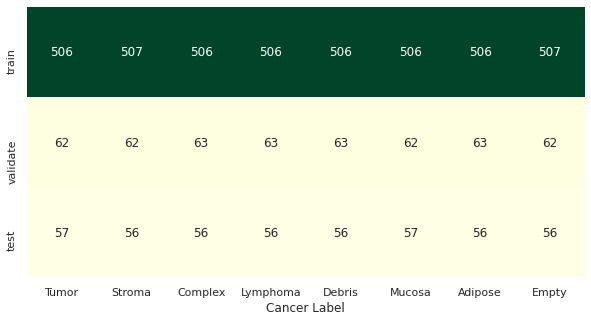

In [6]:
plt.figure(figsize=(10,5))
sns.heatmap(label_counts.transpose(), cmap='YlGn', annot=True, fmt='g', cbar=False, xticklabels=class_names)
plt.xlabel('Cancer Label')
plt.savefig('test_validation_training_intial_distribution.png')

In [7]:
# Encode labels into binary form for easier recognition later. 
label_encoder = LabelEncoder()
label_encoder.fit(class_names)

# Set training, validation and testing x, y values 

X_train = train.drop(['label', 'label_name'], axis=1).values
y_train = label_encoder.transform(train['label_name'].values)

X_validate = val.drop(['label', 'label_name'], axis=1).values
y_validate = label_encoder.transform(val['label_name'].values)

X_test = test.drop(['label', 'label_name'], axis=1).values
y_test = label_encoder.transform(test['label_name'].values)

In [8]:
# Important Sanity Checks:

# Ensure the lengths of the training, test and validation x and y match. 
assert len(X_train) == len(y_train), 'Training Len Mismatch'
assert len(X_validate) == len(y_validate), 'Validate Len Mismatch'
assert len(X_test)  == len(y_test), 'Test Len Msimatch'

In [9]:
# Use min max scaler to set the values of Xs to between 0 and 1. 
# We know that our input can vary between 0 and 255
min_max_scaler = MinMaxScaler()

# Create a fake array with values between 0 and 255 to use for fitting min max scaler
scaling_array = np.append(
    [np.zeros_like(X_train[0], dtype=np.int16)], [np.full_like(X_train[0], 255, dtype=np.int16)], axis=0
)
min_max_scaler.fit(scaling_array)
X_train_scaled = min_max_scaler.transform(X_train)
X_validate_scaled = min_max_scaler.transform(X_validate)
X_test_scaled = min_max_scaler.transform(X_test)

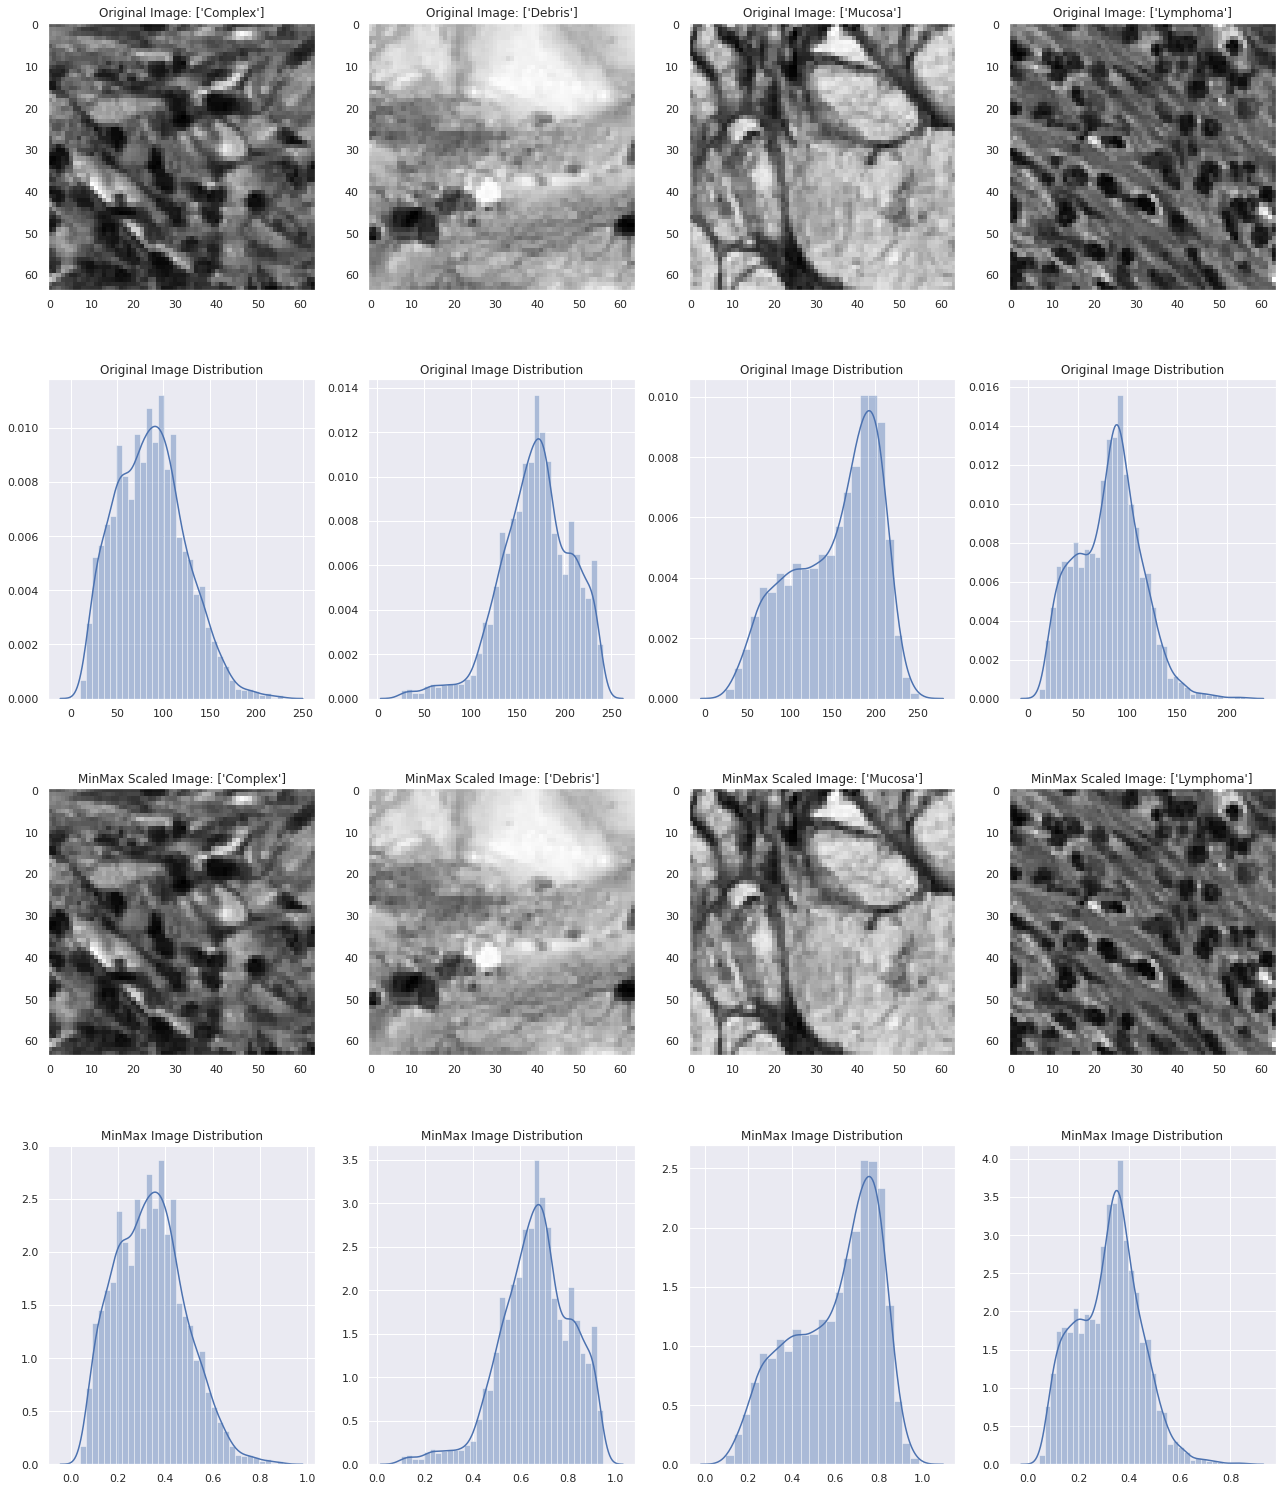

In [10]:
# Lets make sure that that distribution of our data hasn't changed significantly due to scaling. 
# Mostly a sanity check
fig, axs = plt.subplots(4, 4, figsize=(22,27))
for i in range(4):

    # Show Original Images
    original_image = np.reshape(X_train[i], (64,64))
    axs[0,i].imshow(original_image, cmap='gray')
    label_image = label_encoder.inverse_transform([y_train[i]])
    axs[0,i].set_title(f'Original Image: {label_image}')
    axs[0,i].grid(False)

    # Show histogram of values in image:
    sns.distplot(original_image, ax=axs[1,i])
    axs[1,i].set_title('Original Image Distribution')
    axs[1,i].set_ylabel('')

    # Show Scaled Images:
    scaled_image = np.reshape(X_train_scaled[i], (64,64))
    axs[2,i].imshow(scaled_image, cmap='gray')
    label_image = label_encoder.inverse_transform([y_train[i]])
    axs[2,i].set_title(f'MinMax Scaled Image: {label_image}')
    axs[2,i].grid(False)

    # Show histogram of values in image:
    sns.distplot(scaled_image, ax=axs[3,i])
    axs[3,i].set_title('MinMax Image Distribution')
    axs[3,i].set_ylabel('')

plt.savefig('Image Distributions.png')


In [11]:
# Lets start with tpot!
tpot_clf = TPOTClassifier(generations=5, population_size=50, n_jobs=-1, random_state=42, verbosity=2)
tpot_clf.fit(X_train_scaled, y_train)
print(tpot_clf.score(X_test_scaled, y_validate))




TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.


In [ ]:
tpot.export('tpot_colorectal_histology_pipeline.py')